In [60]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
from astropy.table import Table
from scipy.optimize import curve_fit

## redshift dependent mass cut on centrals

In [8]:
def mass(z):
    return -0.1*z**2-0.18*z+11.294

In [61]:
mass(0.3)

11.231

## NFW model

In [69]:
def nfw(r, rs, n):
    x = r / float(rs)
    y = np.piecewise(x, [x < 1, x==1, x > 1],
                     [lambda x:n*(x**2-1)**(-1)*(1-2/np.sqrt(1-x**2)*np.arctanh(np.sqrt((1-x)/(1+x)))), 
                      lambda x:n*1./3, 
                      lambda x:n*(x**2-1)**(-1)*(1-2/np.sqrt(x**2-1)*np.arctan(np.sqrt((x-1)/(1+x))))])
    return y

def fit_nfw(xdata, ydata):
    popt,pcov = curve_fit(nfw, xdata[6:], ydata[6:], p0=[180,4e-5], method='trf')
    return popt

## Mass Surface Density Plot

In [48]:
def combine_deep(mass_bin, csfq, ssfq, z, mode='count'):
    
    def massive_counts(cat_name,z,csfq):
        cat = Table.read('CUT_deep_catalogs/massive_counts/'+cat_name+'_0.09_11.15.fits')
        cat = cat[cat['zphot']==z]
        if len(cat)==0:
            return 0
        
        if csfq=='csf':
            return cat['count_csf'][0]
        elif csfq=='cq':
            return cat['count_cq'][0]
        else:
            return cat['count'][0]
            
    path = 'CUT_deep_catalogs/calibration_deep/'
    radial_COSMOS = np.load(path+mode+'COSMOS_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'.npy')
    radial_DEEP = np.load(path+mode+'DEEP_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'.npy')
    radial_SXDS = np.load(path+mode+'SXDS_uddd_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'.npy')
    radial_ELAIS = np.load(path+mode+'ELAIS_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'.npy')
    radial_XMM = np.load(path+mode+'XMM-LSS_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'.npy')
    
    radial_COSMOS_err = np.load(path+mode+'COSMOS_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'_err.npy')
    radial_DEEP_err = np.load(path+mode+'DEEP_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'_err.npy')
    radial_SXDS_err = np.load(path+mode+'SXDS_uddd_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'_err.npy')
    radial_ELAIS_err = np.load(path+mode+'ELAIS_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'_err.npy')
    radial_XMM_err = np.load(path+mode+'XMM-LSS_deep_'+mass_bin + '_' + csfq + '_' + ssfq+'_'+str(z)+'_err.npy')
    
    count_COSMOS = massive_counts('COSMOS_deep',z,csfq)
    count_DEEP = massive_counts('DEEP_deep',z,csfq)
    count_SXDS = massive_counts('SXDS_uddd',z,csfq)
    count_ELAIS = massive_counts('ELAIS_deep',z,csfq)
    count_XMM = massive_counts('XMM-LSS_deep',z,csfq)
    count_total = sum([count_COSMOS,count_DEEP,count_SXDS,count_ELAIS,count_XMM])

    radial_total = (radial_COSMOS*count_COSMOS+radial_XMM*count_XMM+radial_ELAIS*count_ELAIS+radial_SXDS*count_SXDS+radial_DEEP*count_DEEP)/count_total
    radial_total_err = np.sqrt(radial_COSMOS_err**2*count_COSMOS**2+radial_XMM_err**2*count_XMM**2+radial_ELAIS_err**2*count_ELAIS**2+radial_SXDS_err**2*count_SXDS**2+radial_DEEP_err**2*count_DEEP**2)/count_total
                               
    return radial_total, radial_total_err

[1.88542331e+02 7.32178387e-05]
[1.21448048e+02 1.01223393e-04]
[2.19140262e+02 5.62172248e-05]


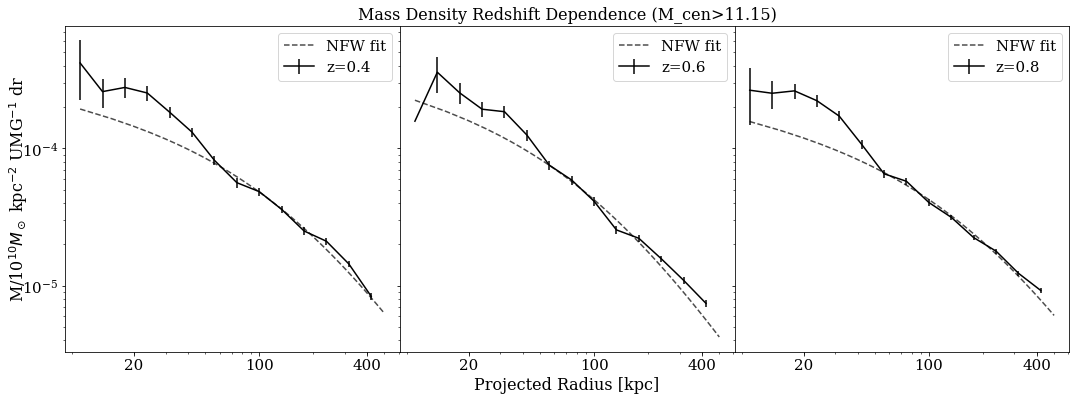

In [80]:
# Mass Surface Density Plot

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(18,6))

mass_radial_4 = combine_deep('9.0','all','all',0.4,mode='mass')
mass_radial_6 = combine_deep('9.0','all','all',0.6,mode='mass')
mass_radial_8 = combine_deep('9.0','all','all',0.8,mode='mass')
bin_edges = np.load('bin_edges.npy')[:-1]

axs[0].errorbar(bin_edges, mass_radial_4[0],mass_radial_4[1],fmt='k',label='z=0.4')
axs[1].errorbar(bin_edges, mass_radial_6[0],mass_radial_6[1],fmt='k',label='z=0.6')
axs[2].errorbar(bin_edges, mass_radial_8[0],mass_radial_8[1],fmt='k',label='z=0.8')

axs[0].set_yscale('log')
axs[0].set_xscale('log')

nfw_x = np.linspace(10,500,num=100)
popt4 = fit_nfw(bin_edges,mass_radial_4[0])
popt6 = fit_nfw(bin_edges,mass_radial_6[0])
popt8 = fit_nfw(bin_edges,mass_radial_8[0])
print(popt4)
print(popt6)
print(popt8)

axs[0].plot(nfw_x,nfw(nfw_x, popt4[0],popt4[1]),'--k',alpha=0.7,label='NFW fit')
axs[1].plot(nfw_x,nfw(nfw_x, popt6[0],popt6[1]),'--k',alpha=0.7,label='NFW fit')
axs[2].plot(nfw_x,nfw(nfw_x, popt8[0],popt8[1]),'--k',alpha=0.7,label='NFW fit')

axs[0].legend(fontsize=15)
axs[1].legend(fontsize=15)
axs[2].legend(fontsize=15)
axs[0].set_xticks([20, 100, 400])
axs[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)

plt.xlabel('Projected Radius [kpc]', fontsize=16)
plt.ylabel(r'M/10$^{10}M_\odot$ kpc$^{-2}$ UMG$^{-1}$ dr', fontsize=16)
plt.title('Mass Density Redshift Dependence (M_cen>11.15)', fontsize=16)
plt.savefig('figures/mass_density_zdependence.png')
plt.show() 

[1.33011811e+02 5.44219061e-05]
[1.31648438e+02 4.30695750e-05]
[2.9668508e+02 1.8337075e-05]


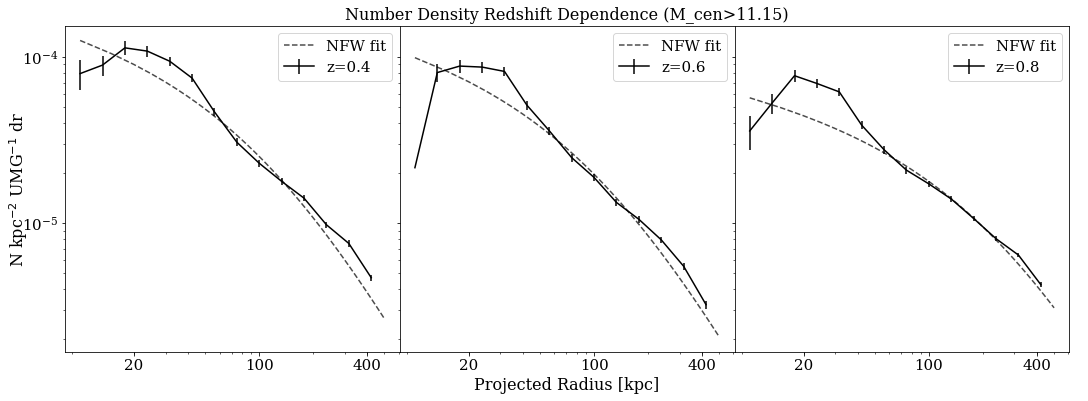

In [81]:
# Number Surface Density Plot


plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(18,6))

count_radial_4 = combine_deep('9.0','all','all',0.4,mode='count')
count_radial_6 = combine_deep('9.0','all','all',0.6,mode='count')
count_radial_8 = combine_deep('9.0','all','all',0.8,mode='count')
bin_edges = np.load('bin_edges.npy')[:-1]

axs[0].errorbar(bin_edges, count_radial_4[0],count_radial_4[1],fmt='k',label='z=0.4')
axs[1].errorbar(bin_edges, count_radial_6[0],count_radial_6[1],fmt='k',label='z=0.6')
axs[2].errorbar(bin_edges, count_radial_8[0],count_radial_8[1],fmt='k',label='z=0.8')

axs[0].set_yscale('log')
axs[0].set_xscale('log')

nfw_x = np.linspace(10,500,num=100)
popt4 = fit_nfw(bin_edges,count_radial_4[0])
popt6 = fit_nfw(bin_edges,count_radial_6[0])
popt8 = fit_nfw(bin_edges,count_radial_8[0])
print(popt4)
print(popt6)
print(popt8)

axs[0].plot(nfw_x,nfw(nfw_x, popt4[0],popt4[1]),'--k',alpha=0.7,label='NFW fit')
axs[1].plot(nfw_x,nfw(nfw_x, popt6[0],popt6[1]),'--k',alpha=0.7,label='NFW fit')
axs[2].plot(nfw_x,nfw(nfw_x, popt8[0],popt8[1]),'--k',alpha=0.7,label='NFW fit')

axs[0].legend(fontsize=15)
axs[1].legend(fontsize=15)
axs[2].legend(fontsize=15)
axs[0].set_xticks([20, 100, 400])
axs[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)


plt.xlabel('Projected Radius [kpc]', fontsize=16)
plt.ylabel(r'N kpc$^{-2}$ UMG$^{-1}$ dr', fontsize=16)
plt.title('Number Density Redshift Dependence (M_cen>11.15)', fontsize=16)
plt.savefig('figures/number_density_zdependence.png')
plt.show() 